In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from io import BytesIO
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### Load and prepare data

#### Load celebrity face dataset from kaggle
The dataset can be downloaded from this link: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
Extract the dataset in the current directory or update the paths in the following cell:

In [7]:
attribute_path = "/list_attr_celeba.csv"
partition_path = "/list_eval_partition.csv"
images_path = "/img_align_celeba/"
batch_size = 128
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"
image_size = (224, 224)

In [8]:
df_attributes = pd.read_csv(attribute_path)

In [9]:
df_attributes.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [12]:
df_attributes.columns.to_list()

['image_id',
 '5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [13]:
df_partition = pd.read_csv(partition_path)

In [15]:
df = pd.merge(df_attributes, df_partition, on="image_id")
df = df.replace(-1,0)
df.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [16]:
# Discard blurry images
df = df[df["Blurry"] ==0].copy()

In [17]:
selected_attributes = ["5_o_Clock_Shadow", "Bald", "Black_Hair", "Blond_Hair", "Brown_Hair",
                       "Eyeglasses", "Goatee", "Gray_Hair", "Male", "Mustache", "Smiling", "No_Beard",
                       "Wearing_Earrings", "Wearing_Hat"]

In [18]:
column_list = ["image_id"]
column_list.extend(selected_attributes)

In [19]:
df_attributes_selected = df[df.columns.intersection(column_list)].copy()

In [21]:
df_attributes_selected.head(5)

,image_id,5_o_Clock_Shadow,Bald,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,Male,Mustache,No_Beard,Smiling,Wearing_Earrings,Wearing_Hat
0,000001.jpg,0,0,0,0,1,0,0,0,0,0,1,1,1,0
1,000002.jpg,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,000004.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,000005.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,000006.jpg,0,0,0,0,1,0,0,0,0,0,1,0,1,0


#### Cleaning the data set

We need to clean the dataset to remove the following faulty instances:

- Instances where the person is not wearing a hat and is not bald, yet no hair colour is assigned.
- Instances where more than one hair colour is assigned to the person.

In [22]:
df_attributes_selected = df_attributes_selected.loc[~(df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] > 1)].copy()

In [23]:
df_attributes_selected = df_attributes_selected.loc[~((df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] == 0) & (df_attributes_selected["Wearing_Hat"] + df_attributes_selected["Bald"] == 0))].copy()

In [24]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    return image

In [25]:
def load_and_preprocess_image(path, *args):
    image = tf.io.read_file(path)
    return preprocess_image(image), *args

In [26]:
def build_dataset_from_df(input_df, attr_list):
    b_list = [input_df[attr] for attr in attr_list]
    b_list.insert(0, [images_path + image_id for image_id in input_df["image_id"]])
    a_tuple = tuple(b_list)
    dataset = tf.data.Dataset.from_tensor_slices(a_tuple)
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    #TODO check the effect of dataset.repeat()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [28]:
train_df = df_attributes_selected.loc[df["partition"] == 0]
train_ds = build_dataset_from_df(train_df, selected_attributes)
val_df = df_attributes_selected.loc[df["partition"] == 1]
val_ds = build_dataset_from_df(val_df, selected_attributes)

In [ ]:
list(train_ds.take(1).as_numpy_iterator())

In [31]:
next_batch = next(iter(train_ds))
print (f"Image shape: {next_batch[0][1].numpy().shape}")
for i in range(len(selected_attributes)):
    print (f"{selected_attributes[i]} shape: {next_batch[i+1].shape}")

Image shape: (224, 224, 3)
5_o_Clock_Shadow shape: (128,)
Bald shape: (128,)
Black_Hair shape: (128,)
Blond_Hair shape: (128,)
Brown_Hair shape: (128,)
Eyeglasses shape: (128,)
Goatee shape: (128,)
Gray_Hair shape: (128,)
Male shape: (128,)
Mustache shape: (128,)
Smiling shape: (128,)
No_Beard shape: (128,)
Wearing_Earrings shape: (128,)
Wearing_Hat shape: (128,)


In [32]:
def text_to_rgba(some_str, *, dpi, **kwargs):
    fig = Figure(facecolor="none")
    fig.text(0, 0, some_str, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba_out = plt.imread(buf)
    return rgba_out

<Figure size 640x480 with 0 Axes>

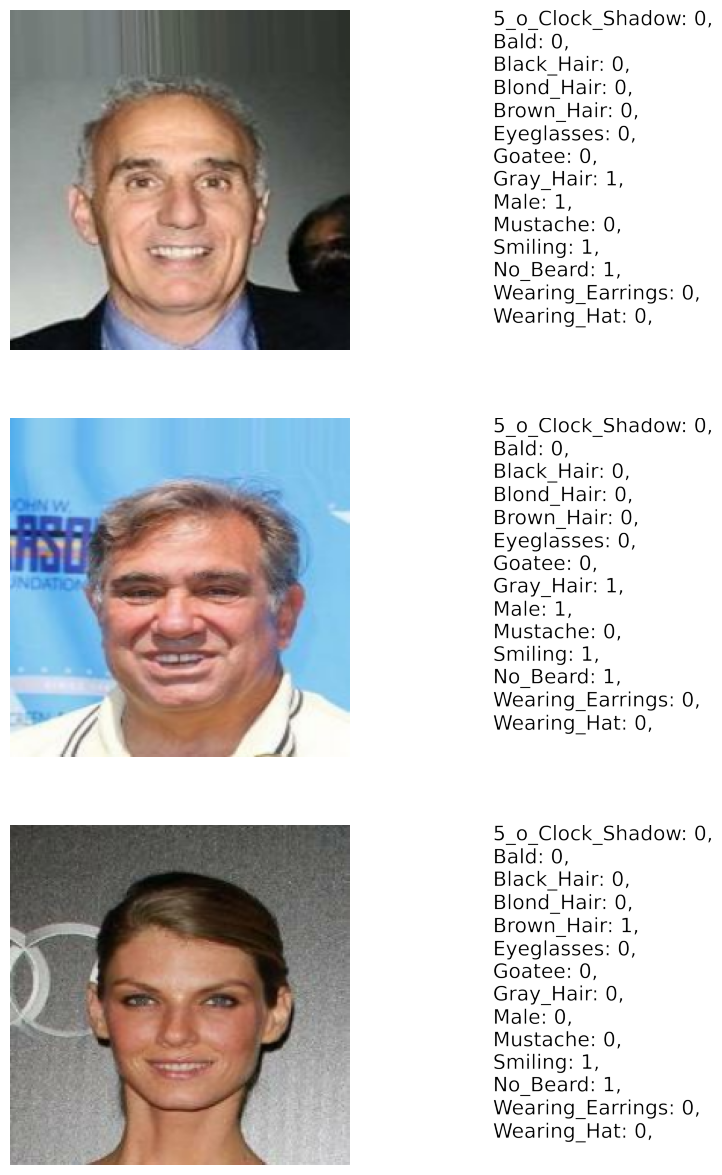

In [33]:
next_batch = next(iter(train_ds))
plt.tight_layout()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axs[i, 0].imshow(next_batch[0][i].numpy().astype("uint8"))
    axs[i, 0].axis("off")
    s = ""
    for j in range (len(selected_attributes)):
        s = s + f"{selected_attributes[j]}: {next_batch[j+1][i].numpy()},\n"
    rgba = text_to_rgba(s, color="black", fontsize=50, dpi=200)
    axs[i, 1].imshow(rgba)
    axs[i, 1].axis("off")

In [34]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

In [35]:
def apply_preprocessing_model(images, *args):
    return (preprocessing_model(images), (args))

In [36]:
def apply_normalization_layer(images, *args):
    return (normalization_layer(images), (args))

In [37]:
train_ds = train_ds.map(apply_preprocessing_model)
val_ds = val_ds.map(apply_normalization_layer)

#### Create Model

In [38]:
do_fine_tuning = False
image_input = tf.keras.Input(shape=image_size + (3,))
en_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(image_input)
en_model = tf.keras.layers.Dropout(rate=0.2)(en_model)
en_model = tf.keras.layers.Dense(128, activation="relu")(en_model)
output_layers = []
for attr in selected_attributes:
    output_layers.append(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=f'{attr}')(en_model))

model = tf.keras.Model( inputs = image_input, outputs = output_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [39]:
model.compile(
    loss = {f"{attr}": tf.keras.losses.BinaryCrossentropy() for attr in selected_attributes},
    metrics = {f"{attr}": [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] for attr in selected_attributes},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

#### Train model

In [ ]:
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

#### Make predictions

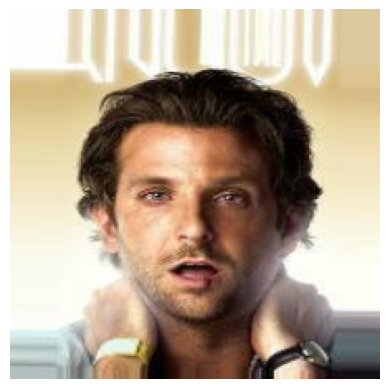

1/1 [==============================] - 0s 61ms/step
5_o_Clock_Shadow: actual 1, predicted 1 (0.8911)
Bald: actual 0, predicted 0 (0.0003)
Bangs: actual 0, predicted 0 (0.0011)
Black_Hair: actual 1, predicted 1 (0.6515)
Blond_Hair: actual 0, predicted 0 (0.0004)
Brown_Hair: actual 0, predicted 0 (0.0634)
Eyeglasses: actual 0, predicted 0 (0.0001)
Goatee: actual 0, predicted 0 (0.3710)
Gray_Hair: actual 0, predicted 0 (0.0025)
Male: actual 1, predicted 1 (0.9981)
Mustache: actual 0, predicted 0 (0.1416)
No_Beard: actual 0, predicted 0 (0.0190)
Sideburns: actual 0, predicted 1 (0.6997)
Smiling: actual 0, predicted 0 (0.0115)
Straight_Hair: actual 0, predicted 0 (0.1267)
Wavy_Hair: actual 1, predicted 0 (0.1617)
Wearing_Earrings: actual 0, predicted 0 (0.0018)
Wearing_Hat: actual 0, predicted 0 (0.0007)
Wearing_Lipstick: actual 0, predicted 0 (0.0014)
Wearing_Necklace: actual 0, predicted 0 (0.0181)
Wearing_Necktie: actual 0, predicted 0 (0.0034)


In [204]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(selected_attributes):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")